<h1>Forecasting Electricity Consumption with LSTM<h1>
<h3>Author: Alfian Rahman</h3>


# Introduction


<p> Time series is one of the important most common analysis that have been done in the data analytics field. There are many methods available to do this type of analysis such as Facebook's <a href="https://facebook.github.io/">Prophet</a>, Auto Regression (AR), Moving Average (MA), Autoregressive Moving Average (ARIMA), Seasonal Autoregressive Integrated Moving Average (SARIMA), etc. In this case, I will give you the example of the implementation of LSTM method to forecast time-series data. We will use the <a href="https://data.gov.ie/dataset/energy-consumption-gas-and-electricity-civic-offices-2009-2012/resource/6091c604-8c94-4b44-ac52-c1694e83d746">2019-2012 Dublin electricity consumption data</a> to demonstrate the implementation of the LSTM method to build a useful model. </p>

# Importing the Modules

<p>First of all, we will import some important modules that will be used in this projects. The modules are: </p>

<ol>
<li> Matplotlib: to visualize the data.
<li> Numpy: to manipulate arrays. 
<li> Pandas: to manipulate a DataFrame or Series object.
<li> Tensorflow: to build our LSTM model. 
<li> ScikitLearn: to split the dataset into train and test datasets.
<li> Statsmodels: to check the stationarity.
</ol>



In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Dense 

# Set the plot styling to Seaborn 
plt.style.use("seaborn")

# Loading the Data

<p>After the needed modules are imported, then we import the data. There are 2 ways to load the data into the notebook: </br>
<ol>
<li> Import the data from local (after the data is downloaded). If you prefer to use this step, the file is attached in the same folder with this notebook. </li>
<li> Import directly from the URL. We will use this step by default. </li>
</ol>
</p>

In [ ]:
# Load data from local 
# df = pd.read_csv("dccelectricitycivicsblocks34p20130221-1840.csv", header=1)

# Load data directly from the URL
url = "https://data.smartdublin.ie/dataset/" + \
      "10130831-d2a5-4f4f-b56b-03d8e2cc56c8/resource/" + \
      "6091c604-8c94-4b44-ac52-c1694e83d746/download/" + \
      "dccelectricitycivicsblocks34p20130221-1840.csv"
df = pd.read_csv(url, header=1)

# Exploratory Data Analysis (EDA)

Let's look around the data. First, we will see the top 5 rows of the data. 

In [ ]:
df.head()

,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,02:00,02:15,02:30,02:45,03:00,03:15,03:30,03:45,04:00,04:15,04:30,04:45,05:00,05:15,05:30,05:45,06:00,06:15,06:30,06:45,07:00,07:15,07:30,07:45,08:00,08:15,08:30,08:45,09:00,09:15,...,14:00,14:15,14:30,14:45,15:00,15:15,15:30,15:45,16:00,16:15,16:30,16:45,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,57.300003,52.950001,48.299999,47.400002,44.550003,40.200001,40.200001,40.500000,40.950001,38.550003,39.000000,36.750000,37.650002,34.950001,34.950001,33.900002,30.300001,31.800003,32.700001,31.800003,31.200001,31.650002,30.600000,32.850002,31.050003,32.100002,31.350002,31.650002,30.150002
1,30/03/2011,96,32.100002,32.400002,33.600002,33.000000,29.700001,30.900002,31.500002,33.000000,31.500000,30.000002,32.850002,27.450001,27.900002,27.900002,32.100002,31.500000,28.799999,33.150002,32.400002,32.400002,34.050003,41.550003,38.250000,47.400002,49.950005,60.300003,58.800003,62.250000,61.350002,66.599998,68.400002,66.000000,71.250000,71.700005,72.450005,74.700005,73.050003,69.750000,...,71.850006,73.050003,72.150002,70.650002,70.800003,73.650002,75.900009,68.250000,69.150002,66.300003,60.450005,52.799999,57.900002,54.450005,53.550003,53.850002,47.850002,47.700001,45.600002,47.850002,46.200001,48.150002,46.200001,40.800003,35.700001,34.200001,34.050003,34.050003,34.200001,33.750004,35.700001,33.600002,34.200001,34.800003,34.650002,33.750000,33.150002,32.700001,31.500002,33.600002
2,31/03/2011,96,32.100002,33.600002,35.100002,33.450001,31.200001,31.350000,34.200001,33.750000,34.650002,35.250000,36.000000,33.600002,35.700001,33.000000,30.750000,31.350002,33.300003,33.150002,33.450001,38.250000,37.650002,41.400002,46.050003,47.850002,46.950001,59.400002,63.150002,63.750000,69.000000,67.200005,69.450005,72.150002,69.900002,73.650002,70.949997,79.199997,74.400002,71.850006,...,74.250000,73.200005,72.000000,73.500000,72.750000,73.350006,75.600006,76.200005,72.900002,75.150002,62.550003,60.450005,57.750000,50.400002,53.850002,50.700005,47.850002,47.100002,47.850002,45.300003,43.800003,43.800003,42.150002,42.600002,42.450005,42.300003,40.500000,38.700001,39.300003,36.000000,33.000000,33.000000,35.250000,34.350002,32.400002,31.200001,32.849998,33.450001,32.100002,32.100002
3,01/04/2011,96,32.700001,34.500000,30.300003,33.000000,33.000000,31.500000,30.300003,32.849998,33.150002,32.700001,33.000000,30.150002,33.000004,31.200001,34.200001,32.400002,34.200001,31.950001,29.400002,36.600002,34.050003,38.100002,39.450001,44.250004,44.850002,52.800003,55.800003,63.300003,63.750004,67.800003,64.949997,69.300003,69.600006,72.600006,74.400002,76.200005,74.550003,72.750000,...,67.200005,73.500000,73.800003,70.200005,70.800003,66.450005,73.500000,72.000000,69.150002,69.750000,60.450001,58.650002,55.350002,57.599998,55.800003,47.400002,46.200001,43.950001,43.050003,42.600002,39.150002,37.200001,34.050003,34.350002,34.650002,33.900002,31.500002,31.950001,34.200001,32.100002,32.250000,33.450001,33.000000,30.450001,33.150002,30.600002,30.150002,32.550003,33.000000,30.150002
4,02/04/2011,96,31.800001,32.400002,30.450001,33.900002,33.300003,30.750002,30.750000,29.850000,28.800001,33.450001,31.800001,33.750000,30.450001,32.400002,30.150002,29.550001,28.500000,33.450001,31.500002,28.800001,32.250000,33.000004,29.850002,35.100002,34.650002,28.500000,32.850002,30.900002,30.150002,31.800001,31.500002,33.450001,32.100002,34.950005,34.800003,32.100002,32.850002,32.700001,...,30.450001,33.300003,28.500002,32.550003,30.900002,30.000002,30.750002,30.600000,32.400002,32.850002,30.450001,30.600002,28.500000,31.950001,29.400002,30.299999,30.300003,31.500002,32.400002,32.850002,29.8

<p>If we look at the top 5 rows, some data are missing (having <i>NaN</i> values). We'll handle this missing later. The data has been pivoted to 15-minute time steps from 00:00 to 23:45.</p>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 98 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    695 non-null    object 
 1   Values  695 non-null    int64  
 2   00:00   694 non-null    float64
 3   00:15   694 non-null    float64
 4   00:30   694 non-null    float64
 5   00:45   692 non-null    float64
 6   01:00   692 non-null    float64
 7   01:15   692 non-null    float64
 8   01:30   692 non-null    float64
 9   01:45   694 non-null    float64
 10  02:00   694 non-null    float64
 11  02:15   694 non-null    float64
 12  02:30   694 non-null    float64
 13  02:45   694 non-null    float64
 14  03:00   694 non-null    float64
 15  03:15   694 non-null    float64
 16  03:30   694 non-null    float64
 17  03:45   694 non-null    float64
 18  04:00   694 non-null    float64
 19  04:15   694 non-null    float64
 20  04:30   694 non-null    float64
 21  04:45   694 non-null    float64
 22  05

<p>If we look at the data information, we have 98 columns with 96 of them are the values for time steps and the first column as the date.</p>

In [ ]:
df["Values"].unique()

array([96])

<p>The second column only contains the same value (96). We don't think it's useful so we can drop that column later. Let's have a look at the rows that have <i>NaN</i> values.</p>

In [ ]:
df[df.isna().sum(axis=1) > 0]

,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,02:00,02:15,02:30,02:45,03:00,03:15,03:30,03:45,04:00,04:15,04:30,04:45,05:00,05:15,05:30,05:45,06:00,06:15,06:30,06:45,07:00,07:15,07:30,07:45,08:00,08:15,08:30,08:45,09:00,09:15,...,14:00,14:15,14:30,14:45,15:00,15:15,15:30,15:45,16:00,16:15,16:30,16:45,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,57.300003,52.950001,48.299999,47.400002,44.550003,40.200001,40.200001,40.500000,40.950001,38.550003,39.000000,36.750000,37.650002,34.950001,34.950001,33.900002,30.300001,31.800003,32.700001,31.800003,31.200001,31.650002,30.600000,32.850002,31.050003,32.100002,31.350002,31.650002,30.150002
3,01/04/2011,96,32.700001,34.500000,30.300003,33.000000,33.000000,31.500000,30.300003,32.849998,33.150002,32.700001,33.000000,30.150002,33.000004,31.200001,34.200001,32.400002,34.200001,31.950001,29.400002,36.600002,34.050003,38.100002,39.450001,44.250004,44.850002,52.800003,55.800003,63.300003,63.750004,67.800003,64.949997,69.300003,69.600006,72.600006,74.400002,76.200005,74.550003,72.750000,...,67.200005,73.500000,73.800003,70.200005,70.800003,66.450005,73.500000,72.000000,69.150002,69.750000,60.450001,58.650002,55.350002,57.599998,55.800003,47.400002,46.200001,43.950001,43.050003,42.600002,39.150002,37.200001,34.050003,34.350002,34.650002,33.900002,31.500002,31.950001,34.200001,32.100002,32.250000,33.450001,33.000000,30.450001,33.150002,30.600002,30.150002,32.550003,33.000000,30.150002
9,07/04/2011,96,32.250000,32.549999,31.950003,30.900002,30.000000,31.350002,34.800003,30.600000,30.300001,31.350000,30.150002,32.250000,32.550003,31.500000,33.300003,34.200001,38.099998,40.200001,42.450001,44.400002,45.450005,56.400002,57.450001,62.100002,63.000004,66.300003,66.450005,71.550003,67.800003,75.000000,76.050003,79.800003,67.050003,71.250000,71.400002,71.849998,73.800003,74.099998,...,78.000000,71.850006,72.900002,71.850006,72.900002,75.000000,77.550003,76.050003,75.150002,74.550003,68.699997,59.850006,59.100006,52.200001,54.000000,50.250000,47.550003,44.250004,43.350002,40.350002,40.200001,45.000004,36.600002,40.350002,38.100002,36.750000,39.600002,33.900002,32.400002,36.750000,35.700005,31.200001,32.850002,31.650002,32.850002,32.550003,34.950005,35.100002,31.200003,33.300003
18,16/04/2011,96,32.549999,28.050001,32.400002,29.700001,30.900002,28.800001,32.850002,30.450001,33.900002,30.600000,31.050003,30.900002,28.950001,32.850002,33.600002,31.350000,30.000002,29.850002,29.100002,28.950001,29.850000,33.000000,29.550001,31.200001,30.000000,33.000000,33.300003,30.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,16/05/2011,96,31.800001,32.400002,31.800001,31.050001,33.450001,31.950003,32.250000,32.100002,32.550003,30.450001,34.200001,28.950001,31.950001,32.549999,32.700001,32.100002,34.650002,30.300001,33.600002,35.100002,33.599998,42.600002,45.900002,42.300003,37.350002,44.250000,46.050003,51.750000,60.900002,64.800003,66.600006,68.700005,NaN,78.150002,80.250000,72.000000,70.650002,69.000000,...,76.800003,71.849998,71.849998,70.650002,72.150002,75.900002,77.400009,75.150002,74.400002,74.850006,61.349998,56.250000,55.950005,52.500004,50.550003,45.450001,44.550003,42.150002,37.650002,40.800003,40.950001,38.700001,36.900002,37.050003,34.500000,32.250004,36.300003,32.700001,30.150000,31.800003,31.350002,32.850002,30.750002,30.900002,30.900002,29.700001,32.700001,32.100002,31.800001,32.849998
76,13/06/2011,96,32.850002,31.950003,32.100002,30.600002,32.400002,31.200001,32.700001,32.700001,31.200001,3

<p>So, we have 12 rows with <i>NaN</i> values. We can fill in this <i>NaN</i> values later. The next step is checking the values relationship with the dates and days. First, we save the dates and days. Furthermore, we will drop the <i>Date</i> and <i>Values</i> columns because we don't need them anymore. Ultimately, we will compare the results from plotting electricity consumption in each time step (15 minute-time step) and each day (Sunday, Monday, etc.).</p>


In [ ]:
df["Date"] = pd.to_datetime(df["Date"]) # Convert Date column to datetime 

# Get the weekday name ("Sunday", "Monday", etc.)
days = df["Date"].dt.day_name().values 

df = df.drop(columns=["Date", "Values"]) # Drop the unused columns

# Prepare for data plotting (top figure)
times = df.columns.values
mean_per_times = df.mean().values
mean_per_date = df.mean(axis=1).values 

# Prepare for data plotting (bottom figure)
df_mean_per_days = pd.DataFrame([days, mean_per_date]).T
df_mean_per_days.columns = ["Day", "Electricity Consumption"]

df_mean_per_days["Electricity Consumption"] = \
df_mean_per_days["Electricity Consumption"].astype("float64")

df_mean_per_days = df_mean_per_days \
                   .groupby("Day")["Electricity Consumption"] \
                   .mean().reset_index()

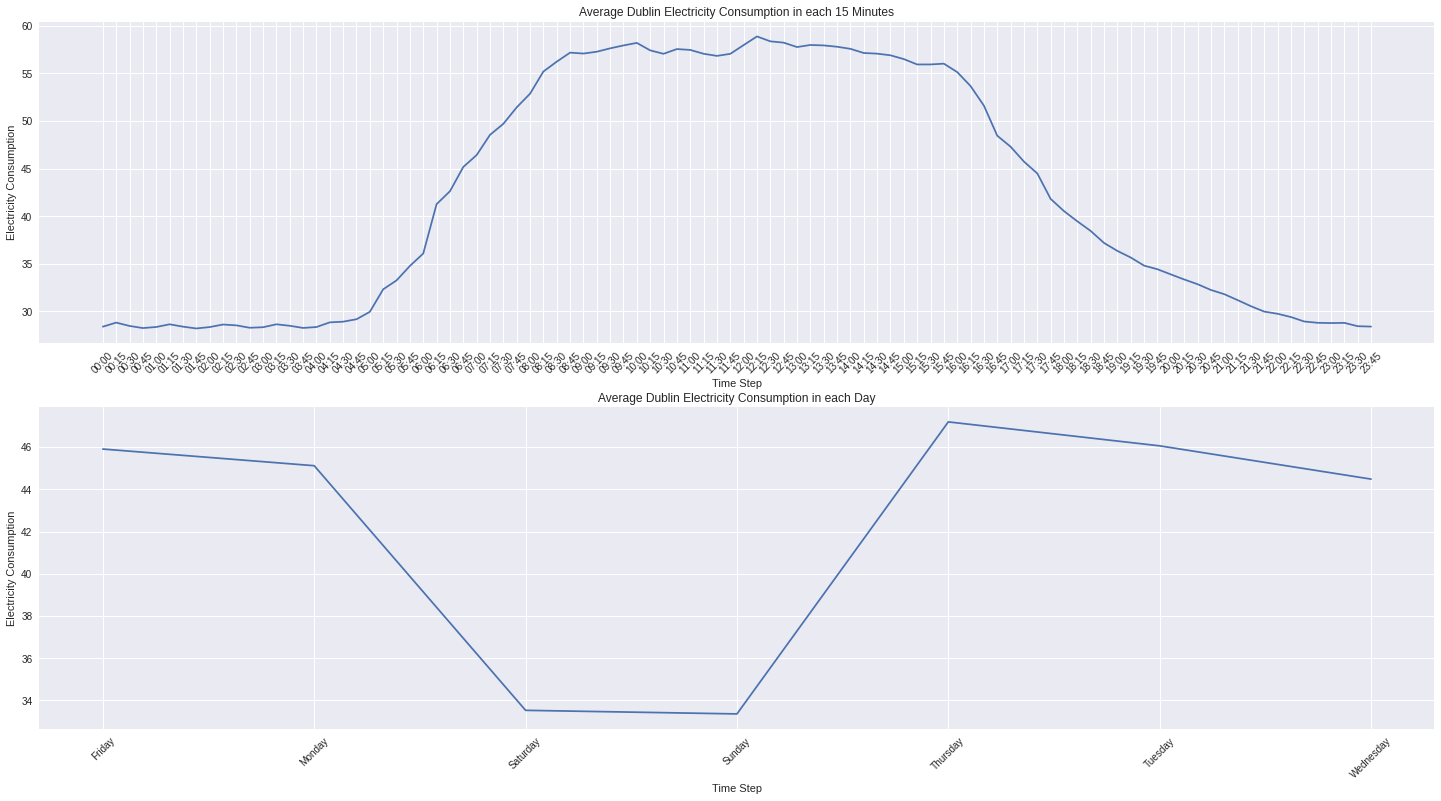

In [ ]:
plt.figure(figsize=(25, 13))

plt.subplot(2, 1, 1)
plt.plot(times, mean_per_times)
plt.xticks(rotation=45)
plt.title("Average Dublin Electricity Consumption in each 15 Minutes")
plt.xlabel("Time Step")
plt.ylabel("Electricity Consumption")

plt.subplot(2, 1, 2)
plt.plot(df_mean_per_days["Day"], df_mean_per_days["Electricity Consumption"])
plt.xticks(rotation=45)
plt.title("Average Dublin Electricity Consumption in each Day")
plt.xlabel("Time Step")
plt.ylabel("Electricity Consumption")

plt.show()

<p> From the 2 above figures, we can infer some important information. If we look at the top figure, the electricity consumption gets higher at the working hours. Moreover, the bottom figure emphasizes that most of the electricity users most probably come from <b>office building</b>. </br> 

Why? </br>

Because on Saturday and Sunday, when the office normally is closed, the consumption drops. The drop is around 26% from the normal working days.
</p>

# Stationarity Test


<p>In order to make the data ready to be analyzed in time-series basis, we need to reformat the data into a flatten format. Before doing that, we will impute the missing values by using the average electricity consumption in each 15-minute time step.</p>

In [ ]:
df = df.fillna(df.mean())

<p>After the missing values are imputed, then we will flatten the data into one row or sequence. This is the typical input format when we deal with time-series data.</p>

In [ ]:
dataset = pd.DataFrame.stack(df).values

print("Dataset: ")
print(dataset)

Dataset: 
[28.39596579 28.82262286 28.47190241 ... 26.         26.5
 26.5       ]


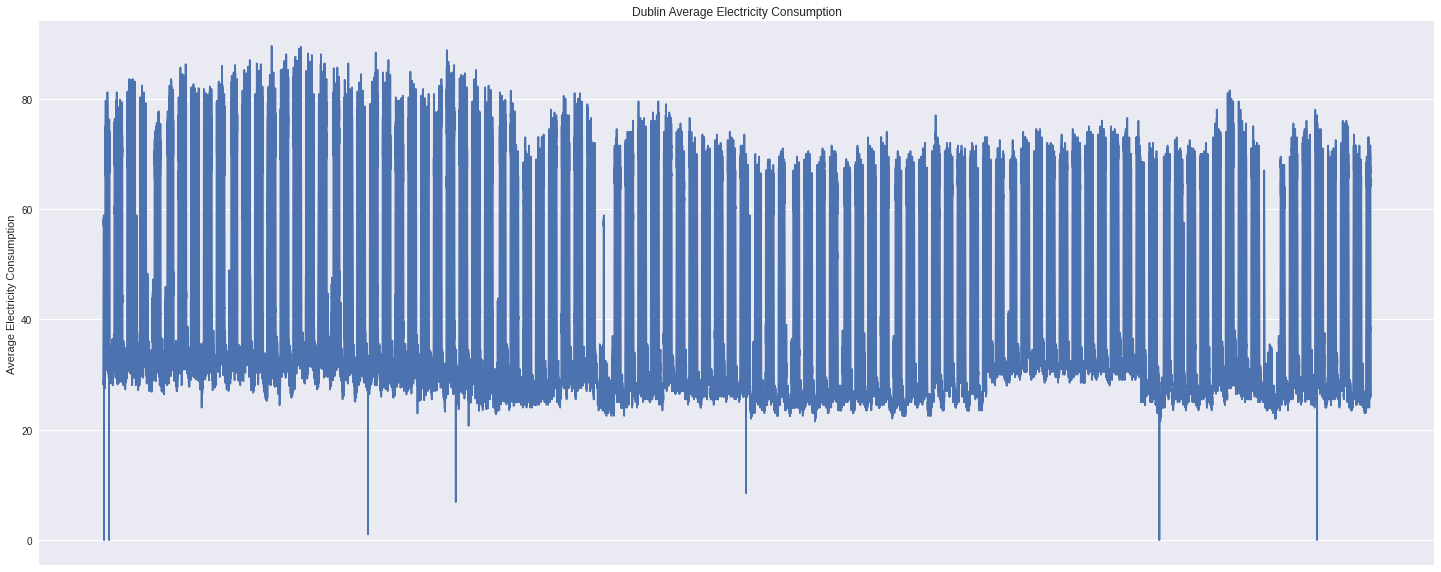

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(dataset)
plt.xticks([], [])
plt.ylabel("Average Electricity Consumption")
plt.title("Dublin Average Electricity Consumption")
plt.show()

<p>We'll check if the data is stationary or not. Stationary data means the data is not affected by any trends or seasonality. First, we will check the data distribution, mean, and variance.</p>

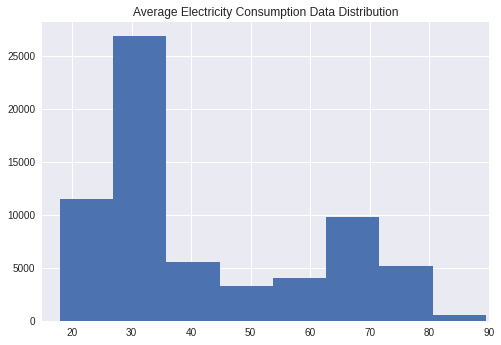

In [ ]:
plt.title("Average Electricity Consumption Data Distribution")
plt.hist(dataset)
plt.xlim([15, 90])
plt.show()

In [ ]:
n_split = round(len(dataset)/2)
X1, X2 = dataset[:n_split], dataset[n_split:]

mean1, mean2 = float(X1.mean()), float(X2.mean())
mean_diff = float(abs(mean2 - mean1) * 100 / mean1)
var1, var2 = float(X1.var()), float(X2.var())
var_diff = float(abs(var2 - var1) * 100 / var1)

print("Mean 1 = {:.2f}, Mean 2 = {:.2f}, Mean Difference = {:.2f}%".format(
       mean1, mean2, mean_diff))
print(("Variance 1 = {:.2f}, Variance 2 = {:.2f}, " + 
      "Variance Difference = {:.2f}%").format(var1, var2, var_diff))

Mean 1 = 44.10, Mean 2 = 40.52, Mean Difference = 8.10%
Variance 1 = 347.83, Variance 2 = 284.95, Variance Difference = 18.08%


<p>From the histogram, we can infer that the dataset is not a bell-shaped (normal) distribution. Furthermore, if we look at the mean and variance, the difference is relatively low (8% and 18%). </br> 
</br>
Next, we wil use the Augmented Dicky Fuller test to check the stationary. This method will check if a dataset has a unit root (non-stationary), which becomes the null hypothesis. 
</p>

In [ ]:
results = adfuller(dataset)

print("ADF Statistic: %f" % results[0])
print("p-value: %f" % results[1])
print("Critical Values:")
for key, value in results[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -14.979473
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


<p>The results of our Augmented Dicky-Fuller test suggests that our data is <b>stationer</b>. It can be shown from the ADF statistic value which is much lower than the any critical values which. It means that the test reject the null hypothesis.</p>

# Data Preparation for Building the LSTM Model

LSTM needs an input of data which has a fixed time steps as features and a value to model. In order to make that kind of input data, we can make a function to prepare that data. 

In [ ]:
def prepare_dataset(dataset, time_step):
    """
    A function to prepare dataset for building Vanilla LSTM model.

    Parameters
    dataset : a list or sequence of time-series values. 
    time_step : number of time steps.

    Returns 
    Array of features: a sequence of features with time-steps. 
    Array of values: a sequnce of values.
    """
    X = []
    y = []
    for i in range(len(dataset)):
        X_arr = dataset[i:i+time_step]
        y_arr = dataset[i+time_step]
        X.append(X_arr)
        y.append(y_arr)
        if i + time_step >= len(dataset) - 1:
            break 
    return np.array(X), np.array(y)


X, y = prepare_dataset(dataset, 3)

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("X samples: ")
print(X[:5])
print("y samples: ")
print(y[:5])

X shape:  (66717, 3)
y shape:  (66717,)
X samples: 
[[28.39596579 28.82262286 28.47190241]
 [28.82262286 28.47190241 28.24956683]
 [28.47190241 28.24956683 28.36242812]
 [28.24956683 28.36242812 28.64472582]
 [28.36242812 28.64472582 28.39812177]]
y samples: 
[28.24956683 28.36242812 28.64472582 28.39812177 28.20857387]


<p>In order to make the data to be ready, we need to reshape the data into (<i>n_samples, time_steps, n_features</i>). In our case, because our data is univariate, we will put 1 to <i>n_features</i>.</p>

In [ ]:
n_samples = X.shape[0]
time_steps = X.shape[1]
n_features = 1

X = X.reshape(n_samples, time_steps, n_features)

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("X samples: ")
print(X[:5])
print("y samples: ")
print(y[:5])

X shape:  (66717, 3, 1)
y shape:  (66717,)
X samples: 
[[[28.39596579]
  [28.82262286]
  [28.47190241]]

 [[28.82262286]
  [28.47190241]
  [28.24956683]]

 [[28.47190241]
  [28.24956683]
  [28.36242812]]

 [[28.24956683]
  [28.36242812]
  [28.64472582]]

 [[28.36242812]
  [28.64472582]
  [28.39812177]]]
y samples: 
[28.24956683 28.36242812 28.64472582 28.39812177 28.20857387]


Then, we split our dataset into train and test dataset. We use 20% of our dataset as test (validation) dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("\n")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (53373, 3, 1)
y_train shape:  (53373,)


X_test shape:  (13344, 3, 1)
y_test shape:  (13344,)


# Bulding the Model Architecture

<p>We'll use the Vanilla LSTM architecture. Vanilla LSTM model consists of a layer of LSTM model then followed by a Dense model. In our case we will use the Huber as loss and SGD as optimizer. </br> 
We also have to determine the minimum MAE target. In our case, we want our MAE is less than 5% of data scale. We use this target in the callback function. In the callback function, we will also make sure that our model is not underfit or overfit. We prevent that by adding a restriction. The restriction is the difference between training MAE and validation MAE must be less than 0.25% of the data scale. 
</p>

In [ ]:
min_mae_target = round(0.05 * (max(dataset) - min(dataset)), 2)
print("Our minimum MAE target (5% data scale) is: ", min_mae_target)

diff_min_mae_target = round(0.0025 * (max(dataset) - min(dataset)), 2)
print("Our difference MAE targets (0.25% data scale) is: ", diff_min_mae_target)

Our minimum MAE target (5% data scale) is:  4.48
Our difference MAE targets (0.25% data scale) is:  0.22


In [ ]:
class ModelTrainingCallback(tf.keras.callbacks.Callback):
    """
    A callback class to stop the training when the conditions are fulfilled.
    """
    def on_epoch_end(self, epoch, logs={}, min_mae_target=min_mae_target, 
                     diff_min_mae_target=diff_min_mae_target):
        """
        Parameter 
        logs (dict) : The model training logs.
        """
        if(logs.get("mae") < min_mae_target \
           and logs.get("val_mae") < min_mae_target) \
           and abs(logs.get("mae") - logs.get("val_mae")) < diff_min_mae_target: 
            print(("\nBoth of the train and validation MAE are already " +
            "less than {} (5% data scale) and the difference of training " +
            "MAE and validation MAE is less than {} (0.25% data scale). " + 
            "Model training is ended.").format(min_mae_target, 
                                               diff_min_mae_target))
            self.model.stop_training = True

callbacks = ModelTrainingCallback()

In [ ]:
# Model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(3, 1)))
model.add(Dense(1))

# Model compilation
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.8)
model.compile(loss="Huber", optimizer=optimizer, metrics="mae")

# Training the Model

In [ ]:
num_epochs = 20

history = model.fit(X_train, y_train, epochs=num_epochs, 
                    validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/20
1668/1668 [==============================] - 5s 3ms/step - loss: 29.8502 - mae: 30.3501 - val_loss: 18.0729 - val_mae: 18.5669
Epoch 2/20
1668/1668 [==============================] - 5s 3ms/step - loss: 14.0012 - mae: 14.4810 - val_loss: 12.5500 - val_mae: 13.0262
Epoch 3/20
1668/1668 [==============================] - 5s 3ms/step - loss: 10.8604 - mae: 11.3300 - val_loss: 9.2643 - val_mae: 9.7278
Epoch 4/20
1668/1668 [==============================] - 5s 3ms/step - loss: 7.7945 - mae: 8.2439 - val_loss: 6.5219 - val_mae: 6.9758
Epoch 5/20
1668/1668 [==============================] - 5s 3ms/step - loss: 5.4886 - mae: 5.9311 - val_loss: 4.4816 - val_mae: 4.9199
Epoch 6/20
1668/1668 [==============================] - 5s 3ms/step - loss: 3.7565 - mae: 4.1948 - val_loss: 3.0120 - val_mae: 3.4451
Epoch 7/20
1668/1668 [==============================] - 5s 3ms/step - loss: 2.5726 - mae: 3.0077 - val_loss: 2.1692 - val_mae: 2.6100
Epoch 8/20
1668/1668 [==============================

# Results 

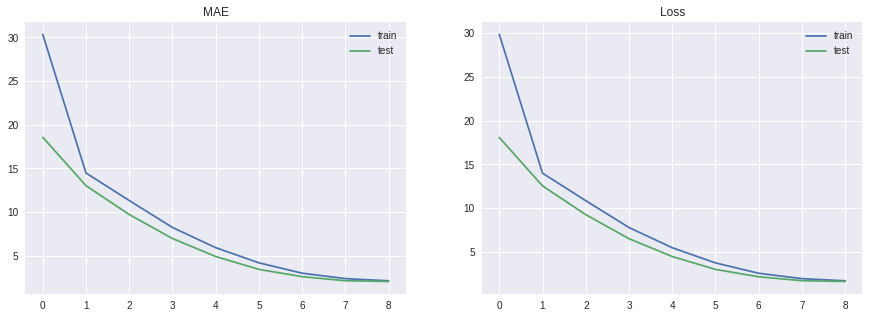

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["mae"], label="train")
plt.plot(history.history["val_mae"], label="test")
plt.title("MAE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Loss")
plt.legend()
plt.show();